# **Download and Import Libraries**

In [ ]:
!pip install kaggle
!pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 12.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
from symspellpy import SymSpell, Verbosity
from google.colab import files
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulrhmanhussein01","key":"721ca4ee483ec124a6c4896364356861"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c nlp-sentiment-analysis-xm

In [ ]:
!unzip nlp-sentiment-analysis-xm.zip

Archive:  nlp-sentiment-analysis-xm.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train.csv               


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_features.csv')

# **EDA**

In [ ]:
train.shape

(1600, 3)

In [ ]:
train.head()

,ID,Text,Category
0,969,@JuliaBradbury @SimonCalder @walsop @HodderPRI...,0
1,241,or here https://t.co/R2tO79Easn … .An in house...,1
2,820,@britshmuseum @thehistoryguy Gosh periscope is...,2
3,693,@Ophiolatrist britishmuseum The stupid #French...,1
4,421,@SassyClde We won't stop til @britishmuseum du...,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        1600 non-null   int64 
 1   Text      1600 non-null   object
 2   Category  1600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 37.6+ KB


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1600.0,997.376875,574.166552,1.0,504.75,999.5,1483.5,2000.0
Category,1600.0,1.504375,1.117256,0.0,1.00,1.0,3.0,3.0


In [ ]:
test.shape

(400, 2)

In [ ]:
test.head()

,ID,Text
0,1861,Goodbye @kettlesyard see you in .25 years! htt...
1,354,"@BBC_Culture @PlymouthMuseum Oh dear, why not ..."
2,1334,Fantastic @johnmcdonnellMP standing up for wor...
3,906,"@BBC_Culture @PlymouthMuseum Oh dear, why not ..."
4,1290,@britishmuseum @TripAdvisor it is !


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      400 non-null    int64 
 1   Text    400 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


<ipython-input-15-6fb6c1840e1c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=train, palette='viridis')


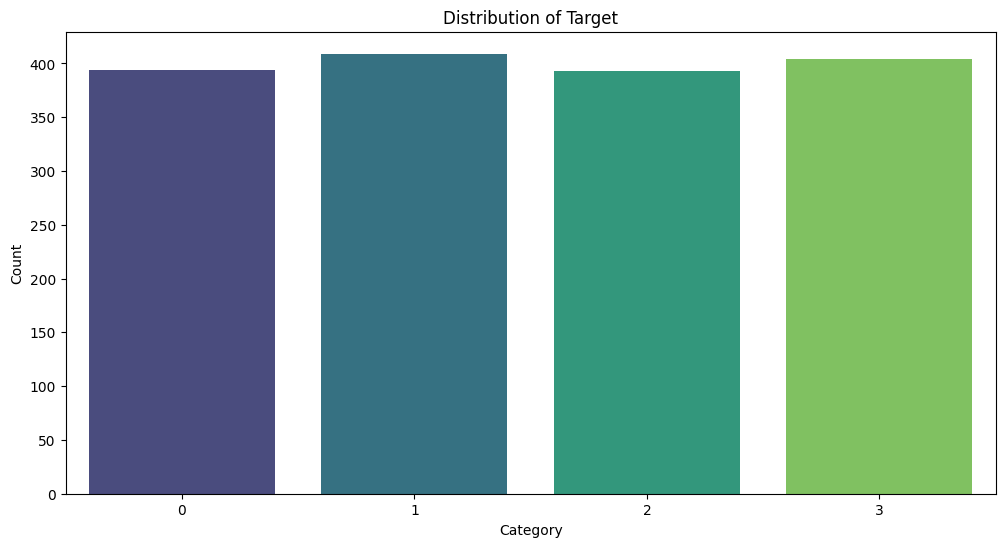

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Category', data=train, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.show()

# **Data Cleaning and Preprocess**

In [ ]:
# prompt: lower casing

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train['Text'] = train['Text'].apply(clean_text)
test['Text'] = test['Text'].apply(clean_text)


In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

train['Text'] = train['Text'].apply(lambda x: remove_urls(x))
test['Text'] = test['Text'].apply(lambda x: remove_urls(x))

In [ ]:
def remove_html_tags(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

train['Text'] = train['Text'].apply(lambda x: remove_html_tags(x))
train['Text'] = train['Text'].apply(lambda x: remove_html_tags(x))

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train['Text'] = train['Text'].apply(lambda x: remove_emoji(x))
train['Text'] = train['Text'].apply(lambda x: remove_emoji(x))

In [ ]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

train['Text'] = train['Text'].apply(lambda x: remove_punctuation(x))
train['Text'] = train['Text'].apply(lambda x: remove_punctuation(x))

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

train['Text'] = train['Text'].apply(lambda x: remove_stopwords(x))
train['Text'] = train['Text'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Training and Evaluation**

In [ ]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing text
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

train_texts, val_texts, train_labels, val_labels = train_test_split(train['Text'], train['Category'], test_size=0.2)

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Load pre-trained BERT model with a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Check for GPU availability and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the device

# Training Loop
epochs = 3
model.train()
for epoch in range(epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/80 [00:00<?, ?it/s]<ipython-input-25-6486e8d35af1>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 80/80 [00:09<00:00,  8.02it/s, loss=0.013]


In [ ]:
model.eval()
predictions, true_labels = [], []

for batch in val_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions.append(logits.argmax(dim=-1).cpu().numpy())
        true_labels.append(batch['labels'].cpu().numpy())

# Flatten predictions and true labels
predictions = [item for sublist in predictions for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Validation Accuracy: {accuracy}')

<ipython-input-25-6486e8d35af1>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Precision: 0.9812529973965469
Recall: 0.98125
F1 Score: 0.9812333987387326
Validation Accuracy: 0.98125
